In [1]:
import numpy as np
from stats import LinearSolveStats, TimeStepStats
from stats import TimeStepStats
from matplotlib import pyplot as plt
from plot_utils import *

# data = load_data("../stats/fpm_2_closed_sticking_solver_1_numba.json")
# data = load_data("../stats/fpm_2_closed_sliding_solver_1_numba.json")
# data = load_data("../stats/fpm_2_closed_open_solver_1_numba.json")
# data = load_data("../stats/fpm_2_closed_m_sliding_solver_1_numba.json")

data = load_data("../stats/fpm_0_sticking_solver_1_numba.json")
# data = load_data("../stats/fpm_0_sliding_solver_1_numba.json")
# data = load_data("../stats/fpm_0_open_solver_1_numba.json")

# data = load_data("../stats/fpm_1_sticking_solver_1_numba.json")
# data = load_data("../stats/fpm_1_sliding_solver_1_numba.json")
# data = load_data("../stats/fpm_1_open_solver_1_numba.json")

# data = load_data("../stats/fpm_01_open_solver_1_numba.json")
# data = load_data("../stats/fpm_01_sticking_solver_1_numba.json")


# data = load_data("../stats/fpm_1_sticking_direct_numba.json")

In [2]:
import porepy as pp
import numpy as np
from mat_utils import *
from plot_utils import *
# from fpm_2_closed_m import make_model
# from fpm_2_closed import make_model
from fpm_0 import make_model
# from fpm_01 import make_model
# from fpm_1 import make_model
# from fpm_1_m import make_model


from pp_utils import make_row_col_dofs, make_reorder_contact

model = make_model()
model.prepare_simulation()

model.before_nonlinear_loop()
model.before_nonlinear_iteration()

model._initialize_solver()
eq_dofs, var_dofs = make_row_col_dofs(model)

reorder = make_reorder_contact(model)


# model.assemble_linear_system()
# mat, rhs = model.linear_system

/home/porepy/porepy/src/porepy/numerics/nonlinear/nonlinear_solvers.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import trange  # type: ignore


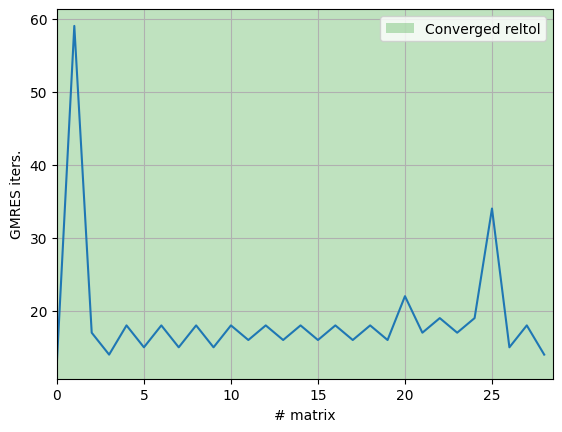

In [3]:
# %matplotlib ipympl
color_converged_reason(data)
plt.plot(get_gmres_iterations(data))
plt.ylabel('GMRES iters.')
plt.xlabel('# matrix')
# plt.yscale('log')
plt.legend()

In [4]:
mat_idx = 10
get_gmres_iterations(data)[mat_idx]

18

In [5]:
sticking, sliding, open_ = get_num_sticking_sliding_open(data)
transition = get_num_transition_cells(data)
sticking = sticking[mat_idx]
sliding = sliding[mat_idx]
open_ = open_[mat_idx]
transition = int(transition[mat_idx])
total = sticking + sliding + open_
print(f'{sticking = }', f'{sliding = }', f'open = {open_}', f'{transition = }', f'{total = }', sep='\n')

sticking = 14
sliding = 0
open = 0
transition = 14
total = 14


In [6]:
from plot_utils import *

mat, rhs, state, iterate, dt = load_matrix_rhs_state_iterate_dt(data, mat_idx)

# model.time_manager.dt = dt
# model.before_nonlinear_loop()
# model.before_nonlinear_iteration()
# model.equation_system.set_variable_values(state, time_step_index=0)
# model.equation_system.set_variable_values(iterate, iterate_index=0)
# model.rediscretize()
# model.assemble_linear_system()

# assert (model.linear_system[0] - mat).data.size == 0
# assert np.all(model.linear_system[1] == rhs)

# mat, rhs = model.linear_system

mat = mat[reorder]
rhs = rhs[reorder]

Solve  took: 0.04


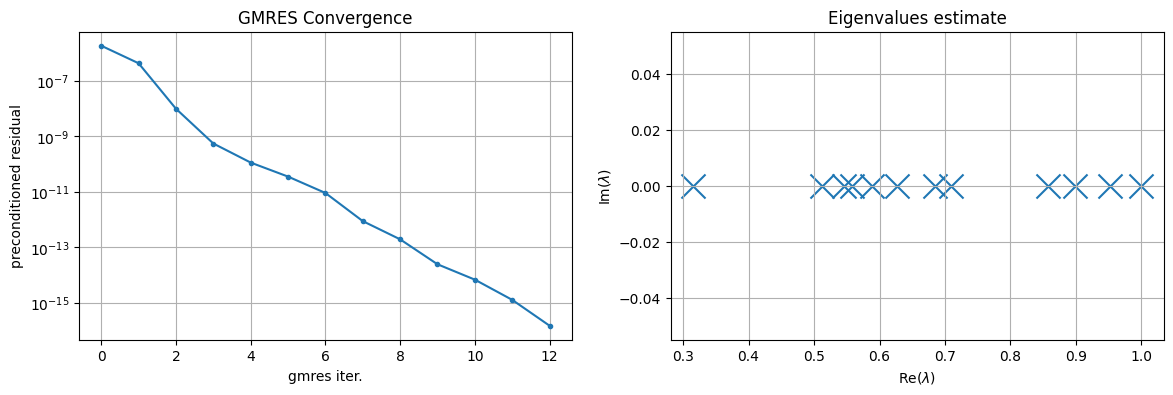

In [7]:
model.linear_system = mat, rhs
model.equation_system.set_variable_values(state, iterate_index=0)
perm_mat, prec_orig = model._prepare_solver()
solve_petsc(perm_mat.mat, prec_orig, rhs=perm_mat.local_rhs(rhs))

In [8]:
gmres = PetscGMRES(mat, pc=prec_orig)
x = gmres.solve(perm_mat.local_rhs(rhs))
perm_mat[[4]].local_rhs(x)

array([ 2.98838740e-17, -1.66170613e-19, -4.19987149e-17, -4.78567682e-20,
        4.10185627e-18,  1.80529629e-19,  2.19403711e-18,  1.93606594e-18,
       -2.50313458e-18, -6.30642801e-20,  2.33084798e-18,  1.74522888e-18,
        2.70301841e-19,  3.61998389e-20,  2.52709323e-19, -4.29995511e-20,
       -3.55389286e-19, -1.65927057e-19, -1.88785871e-19, -4.38720996e-20,
        8.97718709e-19,  5.06607205e-20,  5.02051534e-19,  8.13264237e-20,
       -4.72647944e-17, -1.02967147e-20, -1.61145446e-18,  1.00291666e-19])

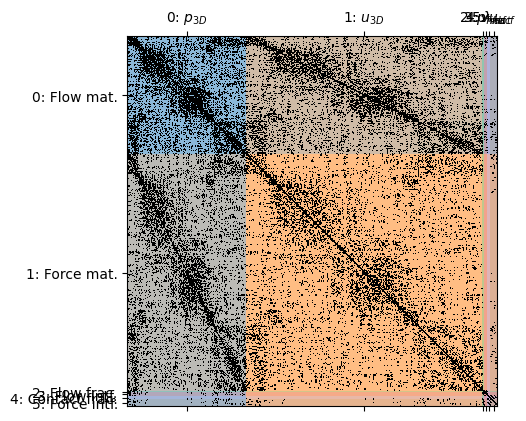

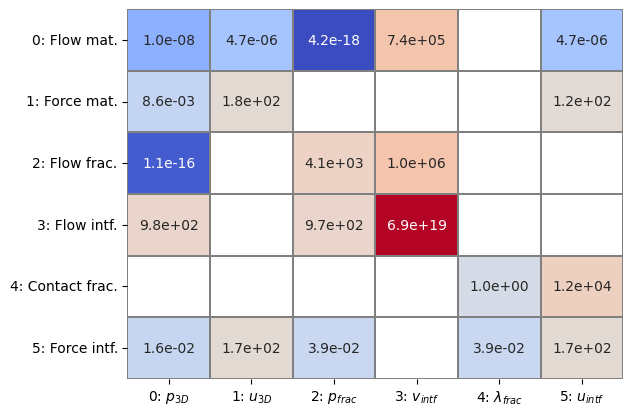

In [9]:
from block_matrix import BlockMatrixStorage
from pp_utils import correct_eq_groups

corrected_eq_dofs, corrected_eq_groups = correct_eq_groups(model)
    
J = BlockMatrixStorage(
    mat=mat,
    global_row_idx=corrected_eq_dofs,
    global_col_idx=model.var_dofs,
    groups_row=corrected_eq_groups,
    groups_col=model._variable_groups,
    # group_row_names=[r'$p_{2D}$', r'$u_{2D}$', r'$p_{1D}$', r'$v_{intf}$', r'$\lambda$', '$u_{intf}$'],
    # group_col_names=[r'$p_{2D}$', r'$u_{2D}$', r'$p_{1D}$', r'$v_{intf}$', r'$\lambda$', '$u_{intf}$']

    # group_row_names=[r'$p_{2D}$', r'$u_{2d}$', r'$p_{1D}$', r'$v_{intf}$', r'$\lambda$', '$u_{intf}$'],
    # group_col_names=[r'$p_{3D}$', r'$u_{3D}$', '', '', '', '']

    group_row_names=[r'Flow mat.', r'Force mat.', r'Flow frac.', r'Flow intf.', r'Contact frac.', 'Force intf.'],
    group_col_names=[r'$p_{3D}$', r'$u_{3D}$', r'$p_{frac}$', r'$v_{intf}$', r'$\lambda_{frac}$', '$u_{intf}$']
)
# plt.figure(figsize=(8, 8))
J[:].color_spy()
J[:].plot_max()
# J[:].matshow()

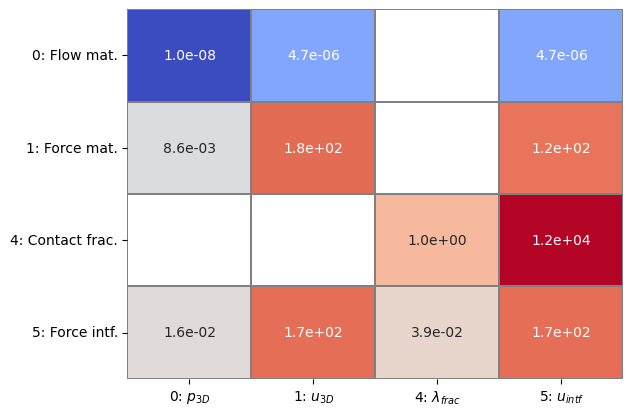

In [10]:
J[[0,1,4,5]].plot_max()

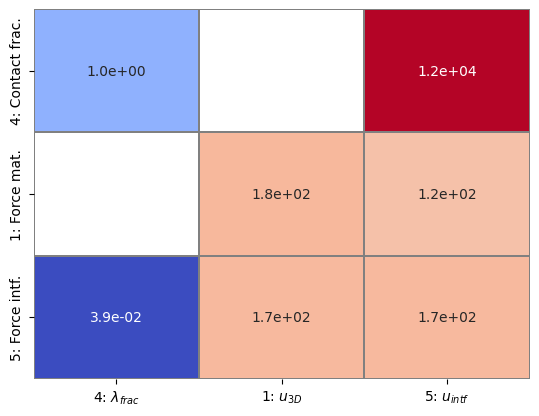

In [11]:
J[[4,1,5]].plot_max()

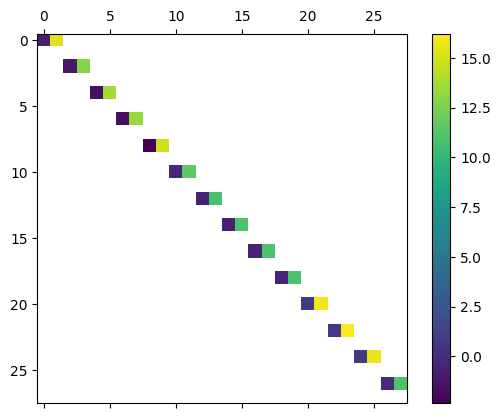

In [12]:
J55_inv = inv_block_diag(J[5, 5].mat, nd=model.nd)
stab_baseline = - J[4, 5].mat @ J55_inv @ J[5, 4].mat
plot_mat(stab_baseline, log=False)

/home/porepy/.local/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:412: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)
/home/porepy/.local/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:302: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


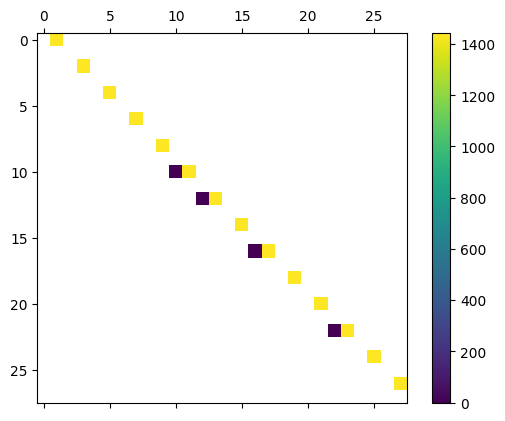

In [13]:
from fixed_stress import make_local_stab_15

stab_new = make_local_stab_15(J, base=4, nd=model.nd)
plot_mat(stab_new, log=False)

/home/porepy/.local/lib/python3.11/site-packages/scipy/sparse/_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


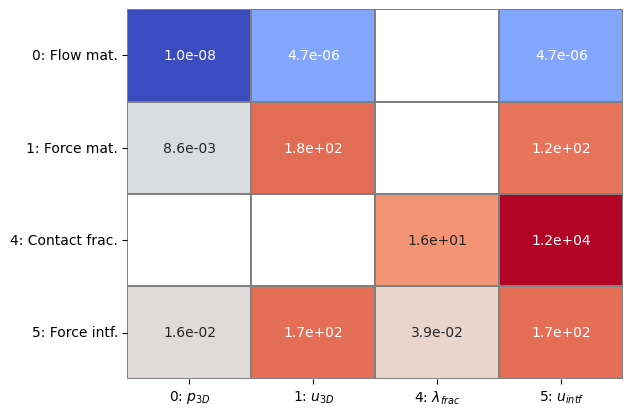

In [14]:
Jstab = J.copy()
# J[4, 4].color_spy()

J55_inv = inv_block_diag(J[5, 5].mat, nd=model.nd)

Jstab[4, 4] = Jstab[4, 4].mat - J[4, 5].mat @ J55_inv @ J[5, 4].mat
# Jstab[4, 4] = Jstab[4, 4].mat + stab_new
# Jstab[4, 1] = Jstab[4, 1].mat - J[4, 5].mat @ J55_inv @ J[5, 1].mat
# Jstab[4, 5] = Jstab[4, 5].mat * 0
# Jstab[4, 0] = Jstab[4, 0].mat - J[4, 5].mat @ J55_inv @ J[5, 0].mat
# Jstab[0, 4] = Jstab[0, 4].mat - J[0, 5].mat @ J55_inv @ J[5, 4].mat
# Jstab[0, 0] = Jstab[0, 0].mat - J[0, 5].mat @ J55_inv @ J[5, 0].mat



Jstab[[0,1,4,5]].plot_max()

/home/porepy/.local/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:412: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)
/home/porepy/.local/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:302: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


Solve  took: 0.06


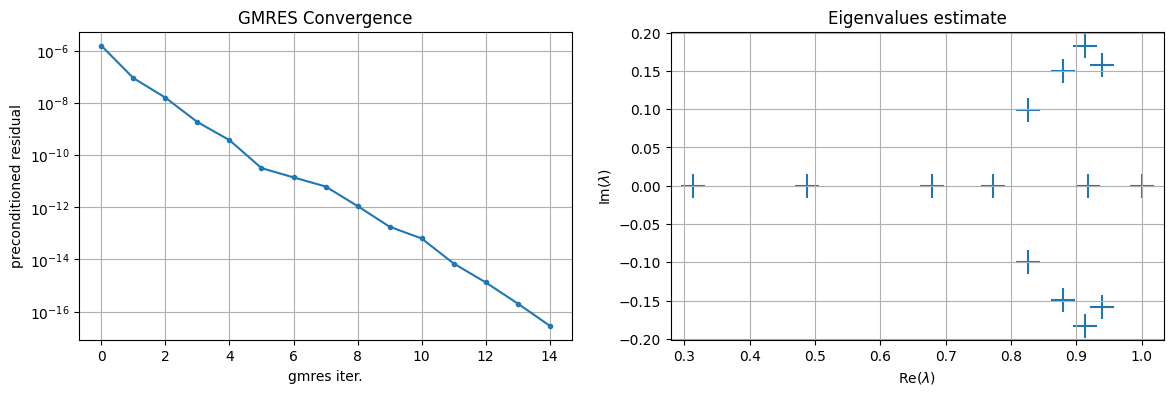

In [15]:
from block_matrix import SolveSchema, make_solver
from preconditioner_mech import make_J44_inv_bdiag
from fixed_stress import make_local_inverse_15
from pp_utils import get_fixed_stress_stabilization


schema = SolveSchema(
    groups=[4],
    solve=lambda bmat: inv_block_diag(Jstab[4, 4].mat, nd=model.nd),
    complement=SolveSchema(
        groups=[1, 5],
        solve=lambda bmat: PetscAMGMechanics(mat=bmat[[1, 5]].mat, dim=model.nd),
        # invertor=lambda bmat: get_fixed_stress_stabilization(model),
        # invertor_type='physical',
        invertor=lambda bmat: make_local_inverse_15(bmat, base=2, nd=1),
        complement=SolveSchema(
            groups=[2],
            solve=lambda bmat: PetscAMGFlow(mat=bmat[[2]].mat)
        )
    ),
)
mat_permuted, prec = make_solver(schema=schema, mat_orig=J)
solve_petsc(mat_permuted.mat, prec, mat_permuted.local_rhs(rhs))

# Good one

Solve  took: 0.03


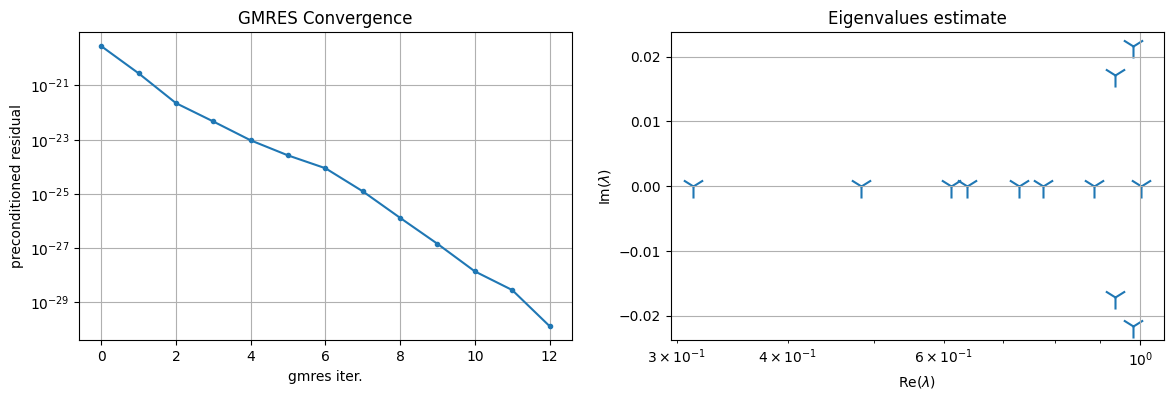

In [16]:
from block_matrix import SolveSchema, make_solver
from pp_utils import get_fixed_stress_stabilization
from fixed_stress import make_local_inverse_15, make_fs

schema = SolveSchema(
    groups=[4],
    solve=lambda bmat: inv_block_diag(bmat[[4]].mat, nd=model.nd),
    # solve=lambda bmat: make_J44_inv_bdiag(bmat[[4]].mat, nd=model.nd),

    complement=SolveSchema(
        groups=[1, 5],
        solve=lambda bmat: PetscAMGMechanics(mat=bmat[[1, 5]].mat, dim=model.nd),
        # invertor=lambda bmat: make_local_inverse_15(bmat, base=2, nd=1),
        # invertor=lambda bmat: get_fixed_stress_stabilization(model),
        # invertor=lambda bmat: make_fs(model, bmat).mat,
        # invertor_type="physical",
        # complement=SolveSchema(
        #     groups=[0, 2],
        #     solve=lambda bmat: PetscAMGFlow(mat=bmat[[0, 2]].mat),
        # ),
    ),
)
mat_permuted, prec = make_solver(schema=schema, mat_orig=Jstab)
solve_petsc(
    mat_permuted.mat, prec, mat_permuted.local_rhs(rhs), tol=1e-10, logx_eigs=True
)

Solve  took: 0.05


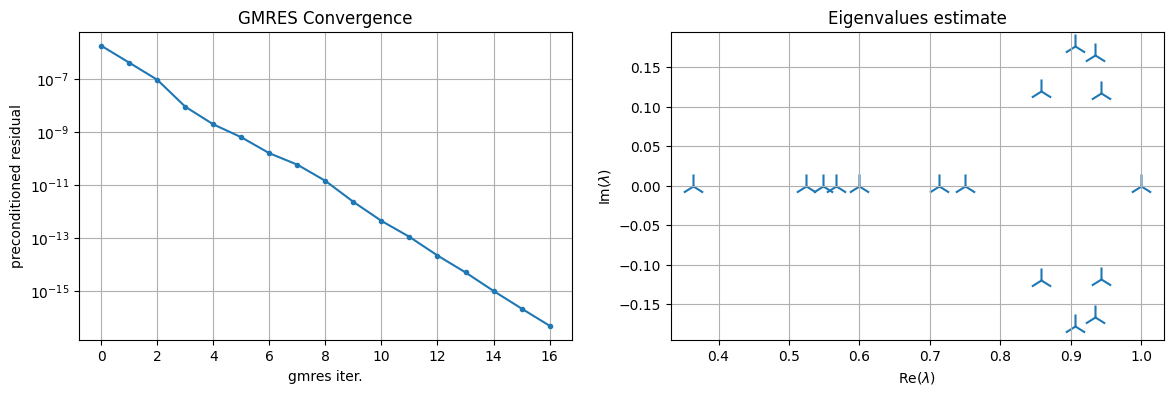

In [26]:
from block_matrix import SolveSchema, make_solver
from pp_utils import get_fixed_stress_stabilization
from fixed_stress import make_local_inverse_15, make_fs

schema = SolveSchema(
    groups=[3],
    solve=lambda bmat: PetscILU(bmat[[3]].mat),
    invertor=lambda bmat: extract_diag_inv(bmat[[3]].mat),
    complement=SolveSchema(
        groups=[4],
        solve=lambda bmat: make_J44_inv_bdiag(model, bmat=bmat),
        complement=SolveSchema(
            groups=[1, 5],
            solve=lambda bmat: PetscAMGMechanics(mat=bmat[[1, 5]].mat, dim=model.nd),
            invertor=lambda bmat: make_fs(model, bmat).mat,
            invertor_type="physical",
            complement=SolveSchema(
                groups=[0, 2],
                solve=lambda bmat: PetscAMGFlow(mat=bmat[[0, 2]].mat),
            ),
        ),
    ),
)
mat_permuted, prec = make_solver(schema=schema, mat_orig=J)
solve_petsc(mat_permuted.mat, prec, mat_permuted.local_rhs(rhs))